### Load Data

In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import argparse
import json
import keras
import numpy as np
import os
import random
import time

import network
import load
import util

Using TensorFlow backend.


In [9]:
import tensorflow as tf
print(tf.keras.__version__)
print(tf.__version__)
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Conv2DTranspose
from keras.utils import np_utils

2.2.4-tf
1.15.0


In [2]:
import tqdm
import scipy.io as sio
STEP = 256

def load_dataset(data_json):
    '''
    return segmented ecgs and lables
    '''
    with open(data_json, 'r') as fid:
        data = [json.loads(l) for l in fid]# just load the filename in data
    labels = []; ecgs = []
    for d in tqdm.tqdm(data):
        labels.extend(d['labels'])
        ecgs.extend(load_ecg(d['ecg']))## load .mat file
    return ecgs, labels

def load_ecg(record):
    '''
    load .mat files and reshape for given STEP=256
    '''
    if os.path.splitext(record)[1] == ".npy":
        ecg = np.load(record)
    elif os.path.splitext(record)[1] == ".mat":
        ecg = sio.loadmat(record[-35:])['val'].squeeze()# hack for different path
    else: # Assumes binary 16 bit integers
        with open(record, 'r') as fid:
            ecg = np.fromfile(fid, dtype=np.int16)

    trunc_samp = STEP * int(len(ecg) / STEP)
    
    return ecg[:trunc_samp].reshape(-1,STEP)

### load data

In [3]:
data_json = "cinc17/train.json"
dev_json = "cinc17/dev.json"
train = load_dataset(data_json)#train[0]: ecg_data train[1]: labels
dev = load_dataset(dev_json)#train[0]: ecg_data train[1]: labels

100%|██████████| 852/852 [00:01<00:00, 569.17it/s]


### data normalization

In [4]:
def scale_input(data):
    '''
    scale the data to [0, 1]
    '''
    data_scaled = [(d - np.min(d))/(np.max(d)-np.min(d)) for d in data]
    scales = [(np.max(d)-np.min(d)) for d in data]
    bias = [np.min(d) for d in data]
    return np.array(data_scaled), np.array(scales), np.array(bias)

In [5]:
train_scaled, scales_train, bias_train = scale_input(train[0])
dev_scaled, scales_train, bias_train = scale_input(dev[0])

### Inject Noise

In [6]:
def add_noise_snr(signals, des_snr, noise_type = 4):
    '''
    add noise to the signal for a given SNR (des_snr)
    ref: https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python
    ------
    params
    signals: ndarray  original signals
    signal_type: int  0: gaussain; 1: cauchy; 2: possion ; 
                      3: speckle: Multiplicative noise using out = image + n*image 
                      4: mix of 0-1 (default)
    des_snr: int desired SNR
    -----
    return
    noisy_signals: ndarray 
    '''
    noisy_signals = []
    for sig in signals:
        # get the power of signal and desired power of noise
        sig_power = np.sum(np.array(sig)**2)/len(sig)
        des_noise_power = sig_power/np.math.pow(10,des_snr/10)
        # generate noise and scale accordingly based on desired SNR
        noise = generate_signals(np.array(sig), noise_type)
        noise_power = np.sum(np.array(noise)**2)/len(noise)
        noise = np.sqrt(des_noise_power/noise_power)*noise
        # append
        noisy_signals.append(sig + noise)
    return np.array(noisy_signals)
def generate_signals(sig, noise_type = 4):
    '''
    generate noises for given sig and noise type
    
    '''
    # TODO: add different noises
    if noise_type == 0: #gaussian
        noise = np.random.normal(size=sig.shape)
    elif noise_type == 1: # cauchy
        from scipy.stats import cauchy
        noise = cauchy.rvs(size=sig.shape) 
    elif noise_type == 2: # poisson
        noise = np.random.poisson(size=sig.shape)
    elif noise_type == 3: # speckle: Multiplicative noise using out = image + n*image,where  n is gaussion noise with specified mean & variance.
        noise = np.random.randn(size=sig.shape)*sig
    else:# mix of 0 & 1 
        from scipy.stats import cauchy
        noise = np.random.normal(size=sig.shape) + cauchy.rvs(size=sig.shape) 
    return noise

In [7]:
#train_mix_db40 = add_noise_snr(train_scaled, des_snr=40, noise_type = 4)
train_mix_db30 = add_noise_snr(train_scaled, des_snr=30, noise_type = 4)
train_mix_db20 = add_noise_snr(train_scaled, des_snr=20, noise_type = 4)
train_mix_db10 = add_noise_snr(train_scaled, des_snr=10, noise_type = 4)

#dev_mix_db40 = add_noise_snr(dev_scaled, des_snr=40, noise_type = 4)
dev_mix_db30 = add_noise_snr(dev_scaled, des_snr=30, noise_type = 4)
dev_mix_db20 = add_noise_snr(dev_scaled, des_snr=20, noise_type = 4)
dev_mix_db10 = add_noise_snr(dev_scaled, des_snr=10, noise_type = 4)

In [273]:
train_gauss_db40 = add_noise_snr(train_scaled, des_snr=40, noise_type = 0)
train_gauss_db30 = add_noise_snr(train_scaled, des_snr=30, noise_type = 0)
train_gauss_db20 = add_noise_snr(train_scaled, des_snr=20, noise_type = 0)
train_gauss_db10 = add_noise_snr(train_scaled, des_snr=10, noise_type = 0)

dev_gauss_db40 = add_noise_snr(dev_scaled, des_snr=40, noise_type = 0)
dev_gauss_db30 = add_noise_snr(dev_scaled, des_snr=30, noise_type = 0)
dev_gauss_db20 = add_noise_snr(dev_scaled, des_snr=20, noise_type = 0)
dev_gauss_db10 = add_noise_snr(dev_scaled, des_snr=10, noise_type = 0)

In [274]:
train_cauchy_db40 = add_noise_snr(train_scaled, des_snr=40, noise_type = 1)
train_cauchy_db30 = add_noise_snr(train_scaled, des_snr=30, noise_type = 1)
train_cauchy_db20 = add_noise_snr(train_scaled, des_snr=20, noise_type = 1)
train_cauchy_db10 = add_noise_snr(train_scaled, des_snr=10, noise_type = 1)

dev_cauchy_db40 = add_noise_snr(dev_scaled, des_snr=40, noise_type = 1)
dev_cauchy_db30 = add_noise_snr(dev_scaled, des_snr=30, noise_type = 1)
dev_cauchy_db20 = add_noise_snr(dev_scaled, des_snr=20, noise_type = 1)
dev_cauchy_db10 = add_noise_snr(dev_scaled, des_snr=10, noise_type = 1)

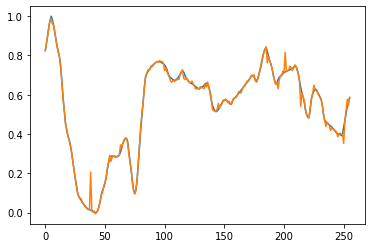

In [10]:
plt.plot(train_scaled[0])
plt.plot(train_mix_db30[0])

### Setup AutoEncoder

In [11]:
lambda_w = 4e-5
input_size = 256
hidden_size = 64
#code_size = 64

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu', kernel_regularizer=l2(lambda_w), bias_regularizer=l2(lambda_w))(x)
#h = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu', kernel_regularizer=l2(lambda_w), bias_regularizer=l2(lambda_w))(hidden_1)
r = Dense(input_size, activation='sigmoid',kernel_regularizer=l2(lambda_w), bias_regularizer=l2(lambda_w))(hidden_2)

autoencoder = Model(inputs=x, outputs=r)
from keras.optimizers import Adam
optimizer = Adam(
    lr = 0.01)
autoencoder.compile(optimizer=optimizer, loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


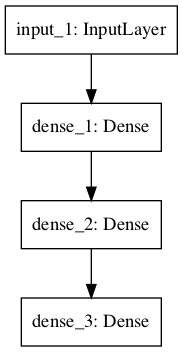

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(autoencoder, dpi=96, to_file='model.png')
#model = model_to_dot(autoencoder).create(prog='dot', format='png')
#model.set_size('48x8')
#SVG(model)

In [16]:
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
MAX_EPOCHS = 50
batch_size = 32
model_filename = 'best_model.h5'
stopping = EarlyStopping(monitor='val_loss', mode='min', min_delta= 0.00005, verbose=1, patience=int(0.15*MAX_EPOCHS))
checkpointer = ModelCheckpoint(filepath= model_filename, monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=int(0.1*MAX_EPOCHS),
                              verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-6)
#history = autoencoder.fit(X_train_cauchy_1d, X_train_1d, batch_size=batch_size, epochs=epochs, 
#                          shuffle = True, verbose=1, validation_data=(X_test_cauchy_1d, X_test_1d), 
#                          callbacks = callbacks) 

In [14]:
np.array(train[0]).shape

(290368, 256)

In [17]:
history = autoencoder.fit(train_mix_db30, train_scaled, batch_size=batch_size, epochs=MAX_EPOCHS, 
                          shuffle = True, verbose=1, validation_data=(dev_mix_db30, dev_scaled), 
                          callbacks = [checkpointer, reduce_lr, stopping])

Train on 290368 samples, validate on 32315 samples
Epoch 1/50
290368/290368 [==============================] - 16s 54us/step - loss: 0.0172 - val_loss: 0.0169
Epoch 2/50
290368/290368 [==============================] - 15s 53us/step - loss: 0.0172 - val_loss: 0.0168
Epoch 3/50
290368/290368 [==============================] - 15s 52us/step - loss: 0.0171 - val_loss: 0.0171
Epoch 4/50
290368/290368 [==============================] - 15s 53us/step - loss: 0.0171 - val_loss: 0.0170
Epoch 5/50
290368/290368 [==============================] - 15s 53us/step - loss: 0.0171 - val_loss: 0.0167
Epoch 6/50
290368/290368 [==============================] - 15s 53us/step - loss: 0.0171 - val_loss: 0.0185
Epoch 7/50
290368/290368 [==============================] - 15s 53us/step - loss: 0.0171 - val_loss: 0.0168
Epoch 8/50
290368/290368 [==============================] - 15s 53us/step - loss: 0.0171 - val_loss: 0.0167
Epoch 9/50
290368/290368 [==============================] - 17s 59us/step - loss: 0.0

## evaluations and visulizations

In [18]:
from keras.models import load_model
saved_model = load_model(model_filename)
decoded_imgs = saved_model.predict(dev_scaled)

In [19]:
def cal_pixel_mse(origin, rec):
    '''
    calculate the mse errors for origin and reconstructed data
    '''
    origin = np.array(origin)
    rec = np.array(rec)
    sample, _ = origin.shape
    mse = []
    for i in range(sample):
        mse.append(np.mean((origin[i]-rec[i])**2))
    return np.array(mse), np.mean(mse)

In [20]:
mse_all, mmse = cal_pixel_mse(dev_scaled, decoded_imgs)
print(f'mmse:{mmse}')

mmse:0.010556138920523416


In [23]:
def visulization(orgin, noisy, decoded):
    '''
    all in one visulization for origin, noisy and reconsturcted data
    
    '''
    n = 3
    plt.figure(figsize=(20, 6))
    for i in range(3*n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.plot(orgin[i])
        plt.plot(decoded[i])
        plt.plot(noisy[i])
        plt.legend(['origin','re-constructed','noisy'])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        #ax = plt.subplot(3, n, i+n+1)
        #plt.plot(decoded[i])
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)
        # display noisy data
        #ax = plt.subplot(3, n, i+2*n+1)
        #plt.imshow(X_test_cauchy_1d[i].reshape(28, 28))
        #plt.gray()
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)

    plt.show()

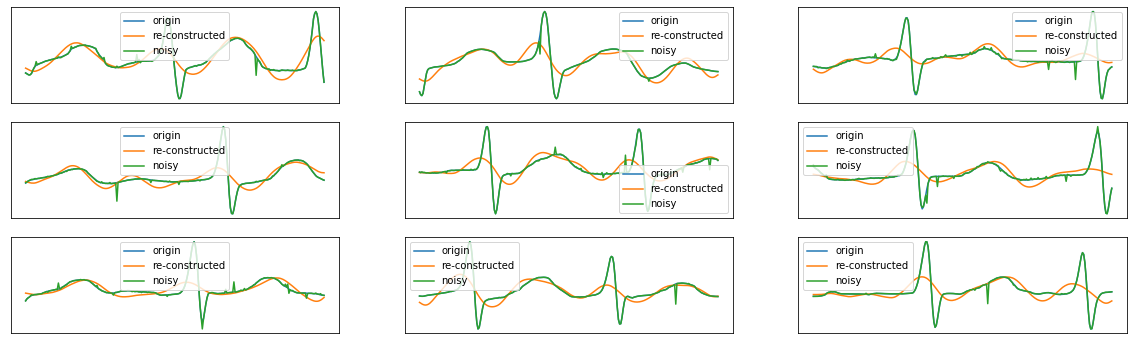

In [24]:
visulization(dev_scaled, dev_mix_db30, decoded_imgs)

## Using MCC Loss

In [25]:
import keras.backend as K 
def mcc_loss(y_actual, y_predicted, sigma = 0.2):
    diff = y_actual-y_predicted
    mcc_loss = -1/K.sqrt(2*K.variable(np.pi))/sigma*K.exp(-diff**2/2/K.variable(sigma)**2)
    return K.mean(mcc_loss)

In [26]:
lambda_w = 4e-5
input_size = 256
hidden_size = 64
#code_size = 64

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu', kernel_regularizer=l2(lambda_w), bias_regularizer=l2(lambda_w))(x)
#h = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu', kernel_regularizer=l2(lambda_w), bias_regularizer=l2(lambda_w))(hidden_1)
r = Dense(input_size, activation='sigmoid',kernel_regularizer=l2(lambda_w), bias_regularizer=l2(lambda_w))(hidden_2)

autoencoder_mcc = Model(inputs=x, outputs=r)
from keras.optimizers import Adam
optimizer = Adam(
    lr = 0.01)
autoencoder_mcc.compile(optimizer='adam', loss = mcc_loss)

In [27]:
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
MAX_EPOCHS = 50
batch_size = 32
mcc_model_name = 'best_model_mcc.h5'
stopping = EarlyStopping(monitor='val_loss', mode='min', min_delta= 0.00005, verbose=1, patience=int(0.15*MAX_EPOCHS))
checkpointer = ModelCheckpoint(filepath=mcc_model_name, monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=int(0.1*MAX_EPOCHS),
                              verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-6)
history_mcc = autoencoder_mcc.fit(train_scaled, train_scaled, batch_size=batch_size, epochs=MAX_EPOCHS, 
                          shuffle = True, verbose=1, validation_data=(dev_scaled, dev_scaled), 
                          callbacks = [checkpointer, reduce_lr, stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 290368 samples, validate on 32315 samples
Epoch 1/50
290368/290368 [==============================] - 20s 70us/step - loss: -1.8975 - val_loss: -1.9406
Epoch 2/50
290368/290368 [==============================] - 20s 69us/step - loss: -1.9449 - val_loss: -1.9483
Epoch 3/50
290368/290368 [==============================] - 18s 61us/step - loss: -1.9494 - val_loss: -1.9488
Epoch 4/50
290368/290368 [==============================] - 18s 60us/step - loss: -1.9508 - val_loss: -1.9506
Epoch 5/50
290368/290368 [==============================] - 18s 61us/step - loss: -1.9512 - val_loss: -1.9526
Epoch 6/50
290368/290368 [==============================] - 20s 68us/step - loss: -1.9517 - val_loss: -1.9531
Epoch 7/50
290368/290368 [==============================] - 20s 68us/step - loss: -1.9520 - val_loss: -1.9508
Epoch 8/50
290368/290368 [==============================] - 21s 71us/step - loss: -1.

### Evaluations and Visulizations

In [39]:
from keras.models import load_model
saved_model_mcc = load_model(mcc_model_name, custom_objects={'mcc_loss': mcc_loss})
dev_mix_mcc_trans = saved_model_mcc.predict(dev_mix_db30)
train_mix_mcc_trans = saved_model_mcc.predict(train_mix_db30)

In [73]:
    params = {
        'data_json': "cinc17/train.json",
        'dev_json': "cinc17/dev.json",
        'des_snr' : 20,
        'noisy_type': 4,
        'train_type': 1, #0: clean-clean 1: noisy-clean 2: noisy-noisy
        'loss': 'mcc',
        'MAX_EPOCHS': 50,
        'batch_size': 32,
        'input_size': 256,
        'hidden_size': 64,
        'lr': 0.01,
        'lambda_w': 4e-5
             }

In [74]:
params.data_json

AttributeError: 'dict' object has no attribute 'data_json'

In [40]:
mse_all_mcc, mmse_mcc = cal_pixel_mse(dev_scaled, dev_mix_mcc_trans)
print(f'mmse:{mmse_mcc}')

mmse:0.0008583612630484054


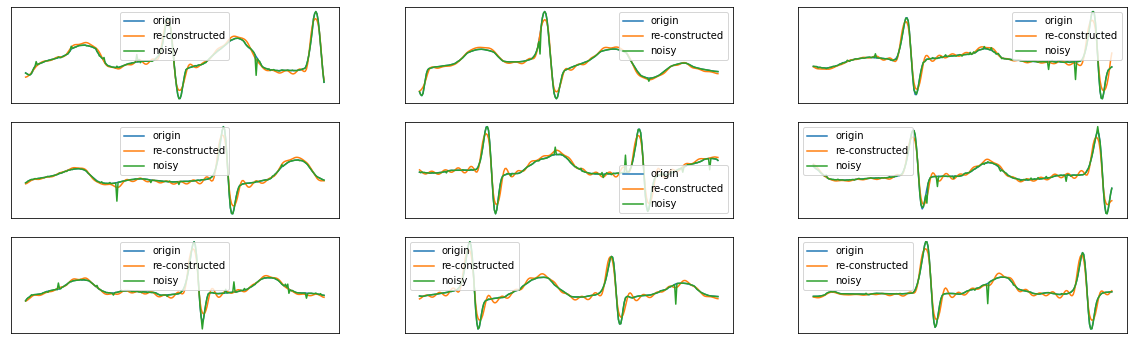

In [41]:
visulization(dev_scaled, dev_mix_db30, dev_mix_mcc_trans)

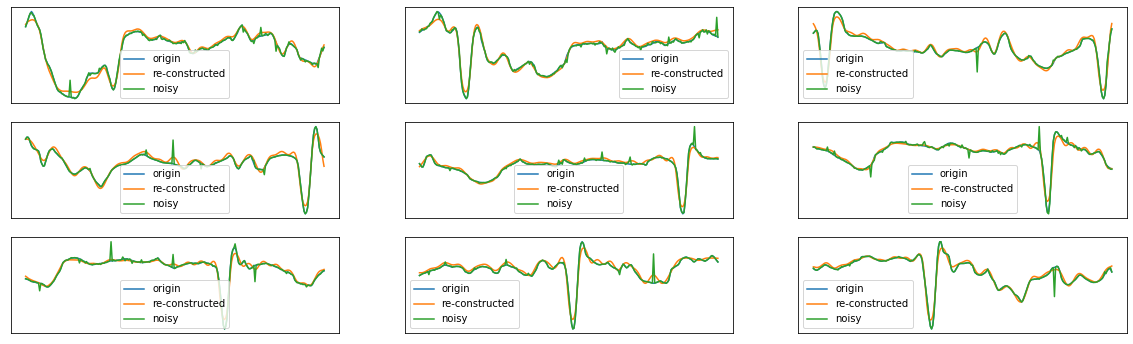

In [42]:
visulization(train_scaled, train_mix_db30, train_mix_mcc_trans)

### store transformed data and json files

In [35]:
def load_dataset_path(data_json):
    '''
    given json file to return the ecgs, lables and orignal path
    ----
    params
    data_json: str. path of the json file
    -----
    return
    
    '''
    with open(data_json, 'r') as fid:
        data = [json.loads(l) for l in fid]# just load the filename in data
    labels = []; ecgs = []; paths = []
    for d in tqdm.tqdm(data):
        paths.append(d['ecg'])
        labels.append(d['labels'])
        ecgs.append(load_ecg_path(d['ecg']))## load .mat file
    return ecgs, labels, paths
def load_ecg_path(record):
    if os.path.splitext(record)[1] == ".npy":
        ecg = np.load(record)
    elif os.path.splitext(record)[1] == ".mat":
        ecg = sio.loadmat(record[-35:])['val'].squeeze()# hack for different path
    else: # Assumes binary 16 bit integers
        with open(record, 'r') as fid:
            ecg = np.fromfile(fid, dtype=np.int16)

    trunc_samp = STEP * int(len(ecg) / STEP)
    
    return ecg[:trunc_samp]

In [37]:
def scale_back(data, scales, bias):
    origin_scale = []
    for d, s, b in zip(data, scales, bias):
        origin_scale.append(d*s + b)
    return np.array(origin_scale)

In [69]:
def transform(origin, model):
    '''
    transform the orignal ecg sginal using the given model
    ----
    params
    origin: list(list)  ecg signals. 
    model: trained  autoencoder
    -----
    return
    tansformed: ndarray of transformed data
    '''
    transformed = []
    for data in origin:
        # reshape and scale
        data = data.reshape(-1,STEP)
        data_scaled, scales, bias = scale_input(data)
        # model predict and scale back
        origin_scale = scale_back(model.predict(data_scaled), scales, bias)
        transformed.append(origin_scale.reshape(-1,1).squeeze())
    return np.array(transformed).squeeze() # keep same dimension as origin[0] data

def scale_back_noisy(origin, segments):
    '''
    transform the segmented ecg sginal using the given model
    ----
    params
    origin: list(list)  ecg signals. 
    segments: list(list) segmented ecg signal based on STEP = 256
    -----
    return
    tansformed: ndarray of transformed data
    '''
    transformed = []
    start = 0
    for data in origin:
        # reshape and scale
        data = data.reshape(-1,STEP)
        _, scales, bias = scale_input(data)
        # model predict and scale back
        data_scaled = segments[start:start+len(data)]
        start += len(data)
        origin_scale = scale_back(data_scaled, scales, bias)
        transformed.append(origin_scale.reshape(-1,1).squeeze())
    return np.array(transformed).squeeze() # keep same dimension as origin[0] data


def transform_segmented(origin, segments, model):
    '''
    transform the segmented ecg sginal using the given model
    ----
    params
    origin: list(list)  ecg signals. 
    segments: list(list) segmented ecg signal based on STEP = 256
    model: trained  autoencoder
    -----
    return
    tansformed: ndarray of transformed data
    '''
    transformed = []
    start = 0
    for data in origin:
        # reshape and scale
        data = data.reshape(-1,STEP)
        _, scales, bias = scale_input(data)
        # model predict and scale back
        data_scaled = segments[start:start+len(data)]
        start += len(data)
        origin_scale = scale_back(model.predict(data_scaled), scales, bias)
        transformed.append(origin_scale.reshape(-1,1).squeeze())
    return np.array(transformed).squeeze() # keep same dimension as origin[0] data

In [44]:
data_json = "cinc17/train.json"
dev_json = "cinc17/dev.json"
train_path = load_dataset_path(data_json)#train[0]: ecg_data train[1]: labels train[2]: path
dev_path = load_dataset_path(dev_json)#train[0]: ecg_data train[1]: labels

100%|██████████| 852/852 [00:00<00:00, 3266.29it/s]


In [70]:
train_mix_db30 = scale_back_noisy(train_path[0], train_mix_db30)
dev_mix_db30 = scale_back_noisy(dev_path[0], dev_mix_db30)

In [46]:
train_origin_mcc_transformed = transform(train_path[0], saved_model_mcc)
train_origin_mse_transformed = transform(train_path[0], saved_model)

In [55]:
train_mix_db30_mcc_transformed = transform_segmented(train_path[0], train_mix_db30, saved_model_mcc)
train_mix_db30_mse_transformed = transform_segmented(train_path[0], train_mix_db30, saved_model)

In [47]:
dev_origin_mcc_transformed = transform(dev_path[0], saved_model_mcc)
dev_origin_mse_transformed = transform(dev_path[0], saved_model)

In [56]:
dev_mix_db30_mcc_transformed = transform_segmented(dev_path[0], dev_mix_db30, saved_model_mcc)
dev_mix_db30_mse_transformed = transform_segmented(dev_path[0], dev_mix_db30, saved_model)

### visual check for the transformed and original data

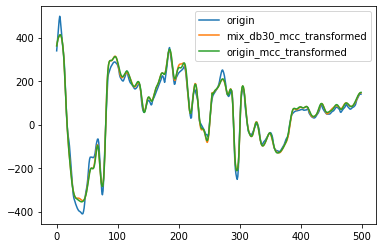

In [58]:
plt.plot(train_path[0][0][0:500])
plt.plot(train_mix_db30_mcc_transformed[0][0:500])
plt.plot(train_origin_mcc_transformed[0][0:500])
plt.legend(['origin','mix_db30_mcc_transformed', 'origin_mcc_transformed'])

### Store The transformed data in .mat and json file .json for later usage

In [59]:
POST_FIX_INDEX = -10 # file_path[-10:] 'AXXXX.mat'
POST_LOCAL_PATH = -35
def save_transformed(path, data, origin_path, experiment_name= 'e'):
    '''
    save the transformed data to the given path
    --------
    params:
    path: str  the path to store the transformed files
    data: ndarray transformed data
    origin_path: original path and name
    experiemnt_name: str identifier for certer experiments 
    '''
    save_dir = make_save_dir(path, experiment_name)
    for d, origin in zip(data, origin_path):
        file_name = get_filename_for_saving(save_dir, origin)
        sio.savemat(file_name, {'val': d})
    return

def make_save_dir(dirname, experiment_name):
    save_dir = os.path.join(dirname, experiment_name)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    return save_dir

def get_filename_for_saving(save_dir, origin):
    return os.path.join(save_dir, origin[POST_FIX_INDEX:])

In [61]:
def save_json(json_path, mat_file_path, file_names, labels, experiment_name = 'e'):
    '''
    params:
    ---------------
    json_path: str   the path and name to store the json file
    mat_file_path: str   the path of previous stored .mat file
    file_names: list(str) the names of original .mat file
    labels: list(list(str)) the label for each seg (STEP=256) of ecg signals
    
    returns:
    --------------
    None
    '''
    with open(json_path, 'w') as fid:
        for name, label in zip(file_names, labels):
            save_dir = os.path.join(mat_file_path, experiment_name)
            datum = { 'ecg' : save_dir+'/'+name[POST_FIX_INDEX:],
                     'labels': label}
            json.dump(datum, fid)
            fid.write('\n')

### Save Orinal Tranformed

In [60]:
# save transformed data to .mat files in given dir
path_origin_train_mcc = 'cinc17/mcc_transformed/origin_train_mcc/'
path_origin_dev_mcc = 'cinc17/mcc_transformed/origin_dev_mcc/'
save_transformed(path_origin_train_mcc, train_origin_mcc_transformed, train_path[2])
save_transformed(path_origin_dev_mcc, dev_origin_mcc_transformed, dev_path[2])

In [63]:
path_origin_train_mse = 'cinc17/mcc_transformed/origin_train_mse/'
path_origin_dev_mse = 'cinc17/mcc_transformed/origin_dev_mse/'
save_transformed(path_origin_train_mse, train_origin_mse_transformed, train_path[2])
save_transformed(path_origin_dev_mse, dev_origin_mse_transformed, dev_path[2])

In [62]:
# save the corresonding json files for later usage
mcc_train_json = './cinc17/origin_train_mcc_mix_db30.json'
mcc_dev_json = './cinc17/origin_dev_mcc_mix_db30.json'
save_json(mcc_train_json, 'examples/'+ path_origin_train_mcc, train_path[2], train_path[1])
save_json(mcc_dev_json, 'examples/'+ path_origin_dev_mcc, dev_path[2], dev_path[1])

In [64]:
# save the corresonding json files for later usage
mse_train_json = './cinc17/origin_train_mse_mix_db30.json'
mse_dev_json = './cinc17/origin_dev_mse_mix_db30.json'
save_json(mse_train_json, 'examples/'+ path_origin_train_mse, train_path[2], train_path[1])
save_json(mse_dev_json, 'examples/'+ path_origin_dev_mse, dev_path[2], dev_path[1])

### Save Noisy Tranformed Data

In [65]:
# save transformed data to .mat files in given dir
path_noisy_train_mcc = 'cinc17/mcc_transformed/noisy_train_mcc/'
path_noisy_dev_mcc = 'cinc17/mcc_transformed/noisy_dev_mcc/'
save_transformed(path_noisy_train_mcc, train_mix_db30_mcc_transformed, train_path[2])
save_transformed(path_noisy_dev_mcc, dev_mix_db30_mcc_transformed,  dev_path[2])

path_noisy_train_mse = 'cinc17/mcc_transformed/noisy_train_mse/'
path_noisy_dev_mse = 'cinc17/mcc_transformed/noisy_dev_mse/'
save_transformed(path_noisy_train_mse, train_mix_db30_mse_transformed, train_path[2])
save_transformed(path_noisy_dev_mse, dev_mix_db30_mse_transformed, dev_path[2])

In [66]:
# save the corresonding json files for later usage
mcc_train_json = './cinc17/noisy_train_mcc_mix_db30.json'
mcc_dev_json = './cinc17/noisy_dev_mcc_mix_db30.json'
save_json(mcc_train_json, 'examples/'+ path_noisy_train_mcc, train_path[2], train_path[1])
save_json(mcc_dev_json, 'examples/'+ path_noisy_dev_mcc, dev_path[2], dev_path[1])

# save the corresonding json files for later usage
mse_train_json = './cinc17/nosiy_train_mse_mix_db30.json'
mse_dev_json = './cinc17/noisy_dev_mse_mix_db30.json'
save_json(mse_train_json, 'examples/'+ path_noisy_train_mse, train_path[2], train_path[1])
save_json(mse_dev_json, 'examples/'+ path_noisy_dev_mse, dev_path[2], dev_path[1])

### Save Noisy Data

In [71]:
# save transformed data to .mat files in given dir
path_noisy_train = 'cinc17/mcc_transformed/noisy_train/'
path_noisy_dev = 'cinc17/mcc_transformed/noisy_dev/'
save_transformed(path_noisy_train, train_mix_db30, train_path[2])
save_transformed(path_noisy_dev, dev_mix_db30,  dev_path[2])

In [72]:
# save the corresonding json files for later usage
train_json = './cinc17/noisy_train_mix_db30.json'
dev_json = './cinc17/noisy_dev_mix_db30.json'
save_json(train_json, 'examples/'+ path_noisy_train, train_path[2], train_path[1])
save_json(dev_json, 'examples/'+ path_noisy_dev, dev_path[2], dev_path[1])